In [1]:
# 1.Importing Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from joblib import Parallel, delayed

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import validation_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

### <b>  Loading Dataset

In [2]:
# 2. Loading Train and Test datsets

# Assign Column names and directory
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 
           'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 
           'hours-per-week', 'native-country', 'income']
dir     = r'C:\NTU\1. Data Mining\1. Assignment 1 KNN\Census Income Data Set'

# Training Data
df_train = pd.read_csv(rf"{dir}\adult.data", delimiter=",", names=columns, encoding="utf-8", header=None, skipinitialspace=True)

# Test Data
df_test = pd.read_csv(rf"{dir}\adult.test", names=columns, skiprows=1, header=None, delimiter=",", encoding="utf-8", skipinitialspace=True)
df_test["income"] = df_test["income"].replace({"<=50K.": "<=50K", ">50K.": ">50K"}) 

# Check No:of rows and columns
print("Training data shape: ",  df_train.shape)
print("Test data shape: "    ,  df_test.shape)

Training data shape:  (32561, 15)
Test data shape:  (16281, 15)


In [3]:
df_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
df_train.info() # No direct null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [5]:
df_train.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


### <b>  Data Preprocessing

In [6]:
# Check for Duplicates and Remove if any
n_duplicates = df_train.duplicated().sum()
df_train.drop_duplicates(inplace=True)
print(f"No:of duplicates dropped: {n_duplicates}")

No:of duplicates dropped: 24


In [7]:
# Identified "null values" in the form of '?' and removing them

# Remove any leading, trailing spaces from each string element
df_train = df_train.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Drop "?" values
for col in df_train.columns:
    if (df_train[col] == "?").any():
        print(f"Column '{col}' has missing values ('?')")

nrows_before = len(df_train)
df_train.replace("?", pd.NA, inplace=True)
df_train.dropna(inplace=True)
nrows_after = len(df_train)

print(f"\nNumber of rows dropped: {nrows_before - nrows_after}")


Column 'workclass' has missing values ('?')
Column 'occupation' has missing values ('?')
Column 'native-country' has missing values ('?')

Number of rows dropped: 2398


In [8]:
len(df_train)

30139

In [9]:
df_train.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,30139.000000,3.013900e+04,30139.000000,30139.000000,30139.000000,30139.000000
mean,38.441720,1.897950e+05,10.122532,1092.841202,88.439928,40.934703
std,13.131426,1.056586e+05,2.548738,7409.110596,404.445239,11.978753
min,17.000000,1.376900e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.176275e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.784170e+05,10.000000,0.000000,0.000000,40.000000
75%,47.000000,2.376045e+05,13.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


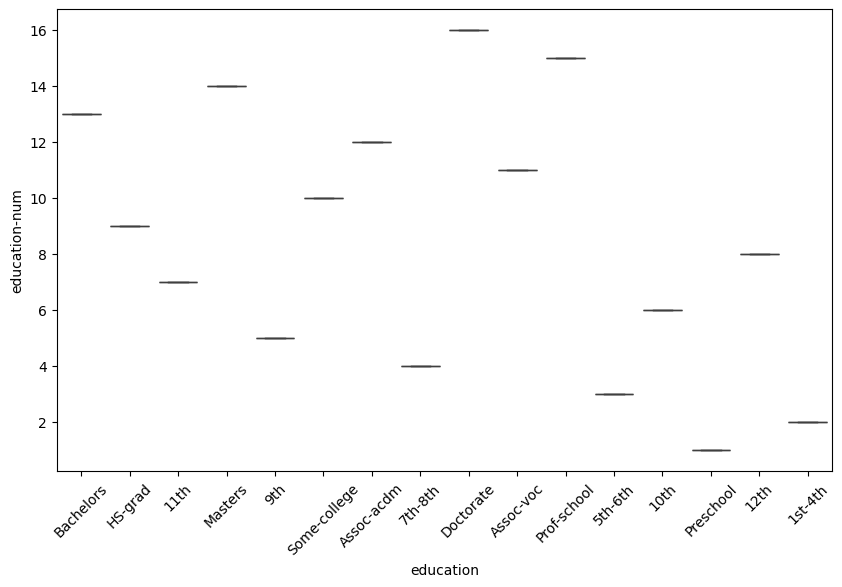

In [10]:
# Box plot of "education" and "education-num"
# drop education-num

plt.figure(figsize=(10, 6))
sns.boxplot(x="education", y="education-num", data=df_train)
plt.xlabel("education")
plt.ylabel("education-num")
plt.xticks(rotation=45)
plt.show()

df_train = df_train.drop(columns="education-num")

In [11]:
df_train["workclass"].unique()

array(['State-gov', 'Self-emp-not-inc', 'Private', 'Federal-gov',
       'Local-gov', 'Self-emp-inc', 'Without-pay'], dtype=object)

In [12]:
df_train["race"].unique()

array(['White', 'Black', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo',
       'Other'], dtype=object)

In [13]:
df_train["native-country"].unique()

array(['United-States', 'Cuba', 'Jamaica', 'India', 'Mexico',
       'Puerto-Rico', 'Honduras', 'England', 'Canada', 'Germany', 'Iran',
       'Philippines', 'Poland', 'Columbia', 'Cambodia', 'Thailand',
       'Ecuador', 'Laos', 'Taiwan', 'Haiti', 'Portugal',
       'Dominican-Republic', 'El-Salvador', 'France', 'Guatemala',
       'Italy', 'China', 'South', 'Japan', 'Yugoslavia', 'Peru',
       'Outlying-US(Guam-USVI-etc)', 'Scotland', 'Trinadad&Tobago',
       'Greece', 'Nicaragua', 'Vietnam', 'Hong', 'Ireland', 'Hungary',
       'Holand-Netherlands'], dtype=object)

In [14]:
df_train["occupation"].unique()

array(['Adm-clerical', 'Exec-managerial', 'Handlers-cleaners',
       'Prof-specialty', 'Other-service', 'Sales', 'Transport-moving',
       'Farming-fishing', 'Machine-op-inspct', 'Tech-support',
       'Craft-repair', 'Protective-serv', 'Armed-Forces',
       'Priv-house-serv'], dtype=object)

In [15]:
# Grouping few column categories

df_train["workclass"]      = np.where(df_train["workclass"] != "Private", "Non-private", df_train["workclass"])
df_train["race"]           = np.where(df_train["race"] != "White", "Non-white", df_train["race"])
df_train["native-country"] = np.where(df_train["native-country"] != "United-States", "Others", df_train["native-country"])

# "marital-status" grouping
marital_status_others = ("Separated", "Widowed", "Married-spouse-absent", "Married-AF-spouse")
df_train["marital-status"] = df_train["marital-status"].map(lambda x: "Others" if x in marital_status_others else x)

# 'education' grouping
assoc = ("Assoc-voc", "Assoc-acdm")
school = ("Preschool", "1st-4th", "5th-6th", "7th-8th", "9th", "10th", "11th", "12th")
df_train["education"] = df_train["education"].map(lambda x: "Associate" if x in assoc else x)
df_train["education"] = df_train["education"].map(lambda x: "School" if x in school else x)

# "occupation" grouping
occupation_others = ("Priv-house-serv", "Armed-Forces")
df_train["occupation"] = df_train["occupation"].map(lambda x: "Others" if x in occupation_others else x)

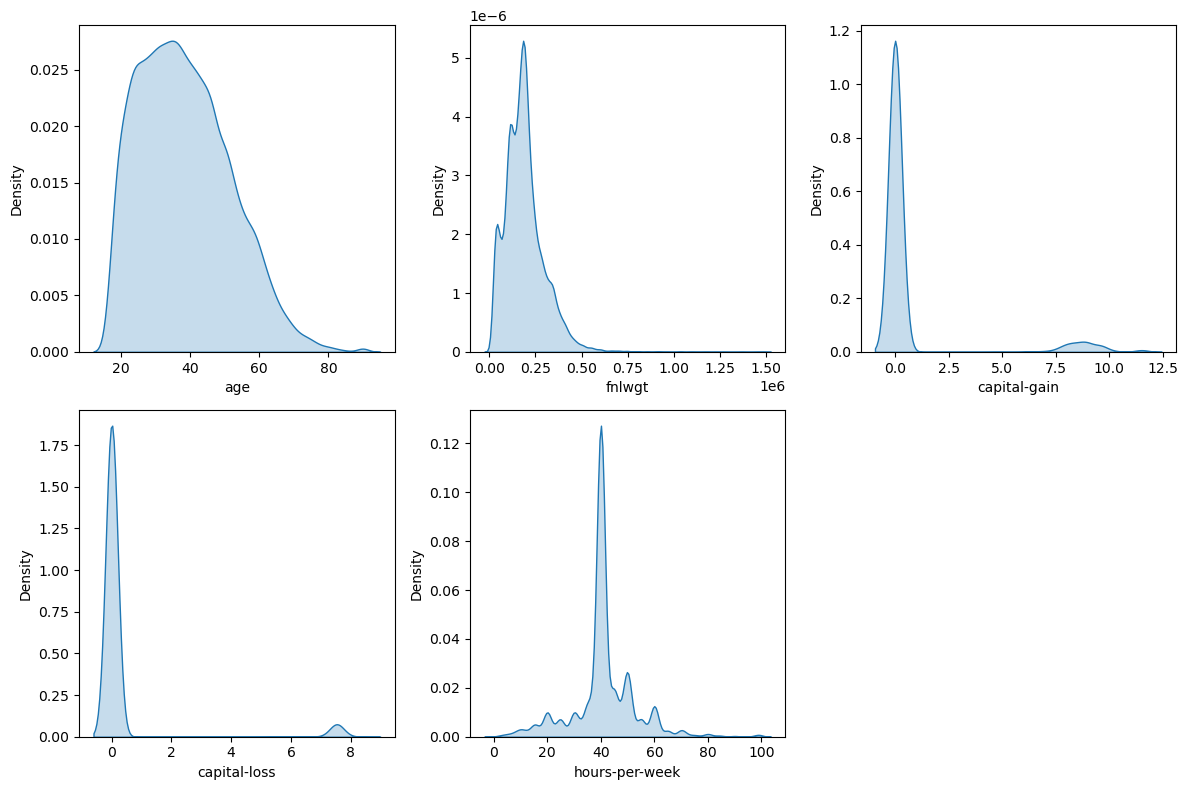

In [16]:
# Log transformation on skewed numerical features and visualization
num_features = df_train.select_dtypes(include='number').columns

# Apply log transformation to 'capital-gain' and 'capital-loss'
df_train["capital-gain"] = np.log1p(df_train["capital-gain"])
df_train["capital-loss"] = np.log1p(df_train["capital-loss"])

# subplots to visualize
fig, axes_list = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
axes_list = axes_list.flatten()  

# KDE plots for each numerical feature
for index, feature in enumerate(num_features):
    sns.kdeplot(df_train[feature], ax=axes_list[index], fill=True)
    axes_list[index].grid(False)  
    axes_list[index].set_xlabel(feature)  
    axes_list[index].set_ylabel("Density")  

# Remove any unused subplot axes
if len(num_features) < 6:
    fig.delaxes(axes_list[len(num_features)])

# Optimize layout and display the plot
plt.tight_layout()
plt.show()

In [17]:
# Create dictionary for label encodings
label_encoder_dict = {}
categorical_cols = df_train.select_dtypes("object").columns

for col in categorical_cols: 
    unique_vals = df_train[col].unique()
    label_encoder_dict[col] = {val: idx for idx, val in enumerate(unique_vals)}  
    df_train[col] = df_train[col].replace(label_encoder_dict[col])

In [18]:
# Normalization using minmax scaler

min_max_scaler = MinMaxScaler()
normalized_data = min_max_scaler.fit_transform(df_train)
df_train = pd.DataFrame(normalized_data, columns=df_train.columns)

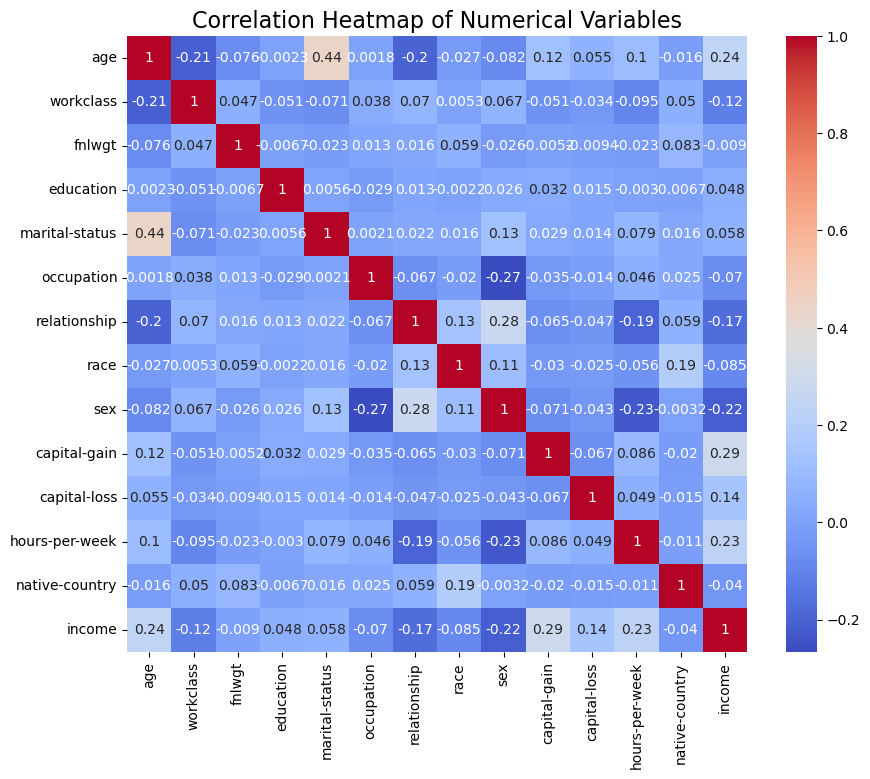

In [19]:
# Correlation heatmap for numerical variables
plt.figure(figsize=(10, 8))
corr_matrix = df_train.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of Numerical Variables", fontsize=16)
plt.show()

In [20]:
# Preprocessing for testing dataset


# Remove duplicates
n_duplicates = df_test.duplicated().sum()
df_test.drop_duplicates(inplace=True)
print(f"No:of duplicates dropped: {n_duplicates}")


# strip and drop "?"
df_test = df_test.applymap(lambda x: x.strip() if isinstance(x, str) else x)

for col in df_test.columns:
    if (df_test[col] == "?").any():
        print(f"Column '{col}' has missing values ('?')")

nrows_before = len(df_test)
df_test.replace("?", pd.NA, inplace=True)
df_test.dropna(inplace=True)
nrows_after = len(df_test)
print(f"\nNumber of rows dropped: {nrows_before - nrows_after}")


# Drop "education-num"
df_test = df_test.drop(columns="education-num")

print(df_test.describe())


df_test["workclass"] = np.where(df_test["workclass"] != "Private", "Non-private", df_test["workclass"])
df_test["education"] = df_test["education"].map(lambda x: "Associate" if x in assoc else x)
df_test["education"] = df_test["education"].map(lambda x: "School" if x in school else x)
df_test["marital-status"] = df_test["marital-status"].map(lambda x: "Others" if x in marital_status_others else x)
df_test["occupation"] = df_test["occupation"].map(lambda x: "Others" if x in occupation_others else x)
df_test["race"] = np.where(df_test["race"] != "White", "Non-white", df_test["race"])
df_test["native-country"] = np.where(df_test["native-country"] != "United-States", "Others", df_test["native-country"])


for col in categorical_cols:
    print(f"{col}: {df_test[col].nunique()}")

df_test["capital-gain"] = np.log1p(df_test["capital-gain"])
df_test["capital-loss"] = np.log1p(df_test["capital-loss"])

for col in categorical_cols:
    df_test[col] = df_test[col].replace(label_encoder_dict[col])

# Min-Max Scaling 
#df_test = pd.DataFrame(min_max_scaler.transform(df_test), columns=df_test.columns)


normalized_data = min_max_scaler.fit_transform(df_test)
df_test = pd.DataFrame(normalized_data, columns=df_test.columns)


No:of duplicates dropped: 5
Column 'workclass' has missing values ('?')
Column 'occupation' has missing values ('?')
Column 'native-country' has missing values ('?')

Number of rows dropped: 1221
                age        fnlwgt  capital-gain  capital-loss  hours-per-week
count  15055.000000  1.505500e+04  15055.000000  15055.000000    15055.000000
mean      38.772036  1.896234e+05   1120.673663     89.071471       40.954234
std       13.380850  1.056081e+05   7704.433932    406.347469       12.062092
min       17.000000  1.349200e+04      0.000000      0.000000        1.000000
25%       28.000000  1.166570e+05      0.000000      0.000000       40.000000
50%       37.000000  1.779550e+05      0.000000      0.000000       40.000000
75%       48.000000  2.385895e+05      0.000000      0.000000       45.000000
max       90.000000  1.490400e+06  99999.000000   3770.000000       99.000000
workclass: 2
education: 8
marital-status: 4
occupation: 13
relationship: 6
race: 2
sex: 2
native-count

In [21]:
# Separate features and target variable using pop method

X_train = df_train.drop(columns=["income"])
y_train = df_train["income"]

X_test = df_test.drop(columns=["income"])
y_test = df_test["income"]

### <b>  K-NN Classifier

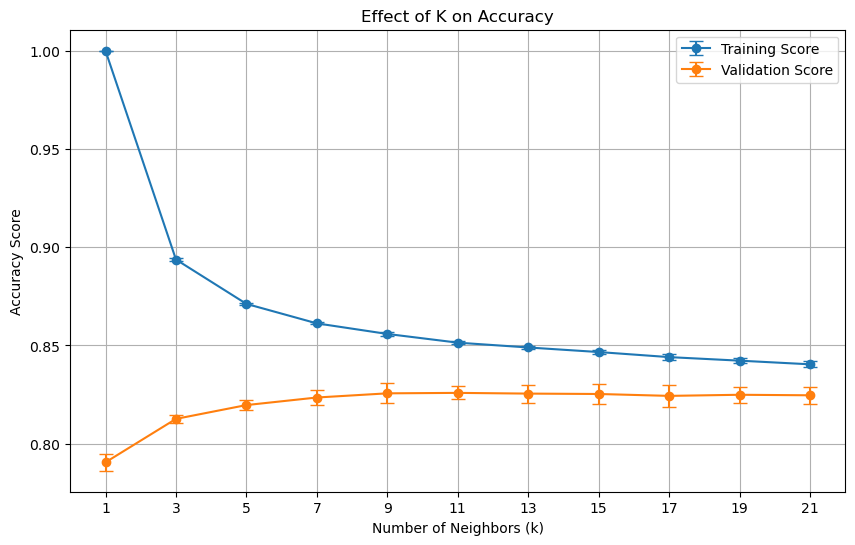

In [22]:
# To Determine best k value for K-NN

k_values = np.arange(1, 22, 2)  

train_scores, valid_scores = validation_curve(
    KNeighborsClassifier(),
    X_train, y_train,
    param_name="n_neighbors",
    param_range=k_values,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

train_means = train_scores.mean(axis=1)
train_stds  = train_scores.std(axis=1)
valid_means = valid_scores.mean(axis=1)
valid_stds  = valid_scores.std(axis=1)

# Plotting 
plt.figure(figsize=(10, 6))
plt.errorbar(k_values, train_means, yerr=train_stds, label="Training Score", marker="o", capsize=5)
plt.errorbar(k_values, valid_means, yerr=valid_stds, label="Validation Score", marker="o", capsize=5)
plt.title("Effect of K on Accuracy")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy Score")
plt.xticks(k_values)
plt.legend()
plt.grid()
plt.show()


In [23]:
# Implementing kNN Algorithm using k=11

knn_model = KNeighborsClassifier(n_neighbors=11)
knn_model.fit(X_train, y_train)

# Prediction
y_pred = knn_model.predict(X_test)

In [24]:
# Evaluate Performance for k = 11
accuracy    = accuracy_score(y_test, y_pred)
precision   = precision_score(y_test, y_pred)
recall      = recall_score(y_test, y_pred)
f1          = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# performance metrics
print(f"Performance Metrics:")
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
print('Confusion Matrix:')
print(conf_matrix)

Performance Metrics:
Accuracy: 0.82
Precision: 0.66
Recall: 0.59
F1-Score: 0.62
Confusion Matrix:
[[10229  1126]
 [ 1534  2166]]


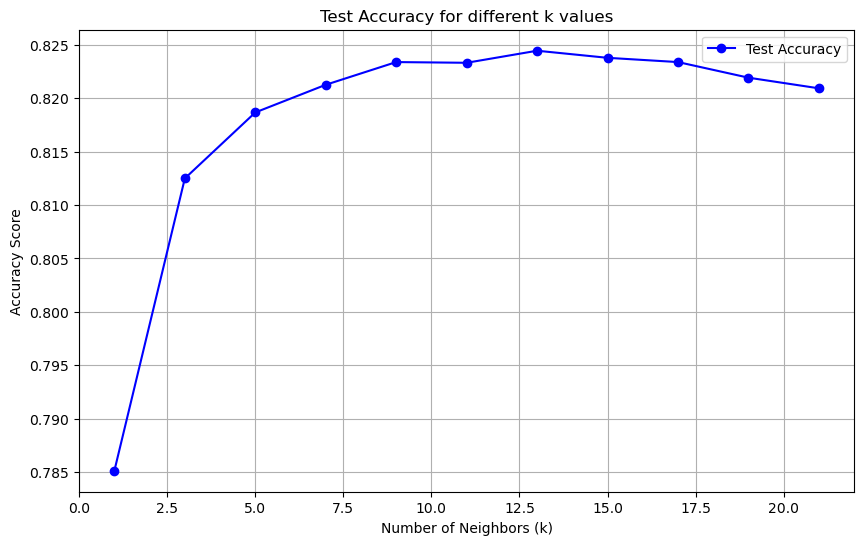

In [25]:
test_accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    test_accuracies.append(accuracy)

plt.figure(figsize=(10, 6))
plt.plot(k_values, test_accuracies, marker='o', linestyle='-', color='b', label='Test Accuracy')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy Score')
plt.title('Test Accuracy for different k values')
plt.legend()
plt.grid()
plt.show()


<Axes: >

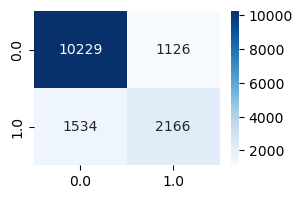

In [26]:
# Plotting the confusion matrix with smaller size
plt.figure(figsize=(3, 2))  # Smaller figure size
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))

